## 4. Evaluation Metrics for Classification 

### 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

- Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-resvb,male,0,yes,yes,24,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,yes,mailed_check,84.80,1990.50,0
7039,2234-xaduh,female,0,yes,yes,72,yes,yes,fiber_optic,no,...,yes,no,yes,yes,one_year,yes,credit_card_(automatic),103.20,7362.90,0
7040,4801-jzazl,female,0,yes,yes,11,no,no_phone_service,dsl,yes,...,no,no,no,no,month-to-month,yes,electronic_check,29.60,346.45,0
7041,8361-ltmkd,male,1,yes,no,4,yes,yes,fiber_optic,no,...,no,no,no,no,month-to-month,yes,mailed_check,74.40,306.60,1


In [5]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [6]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [7]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [8]:
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

/usr/local/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

### Accuracy

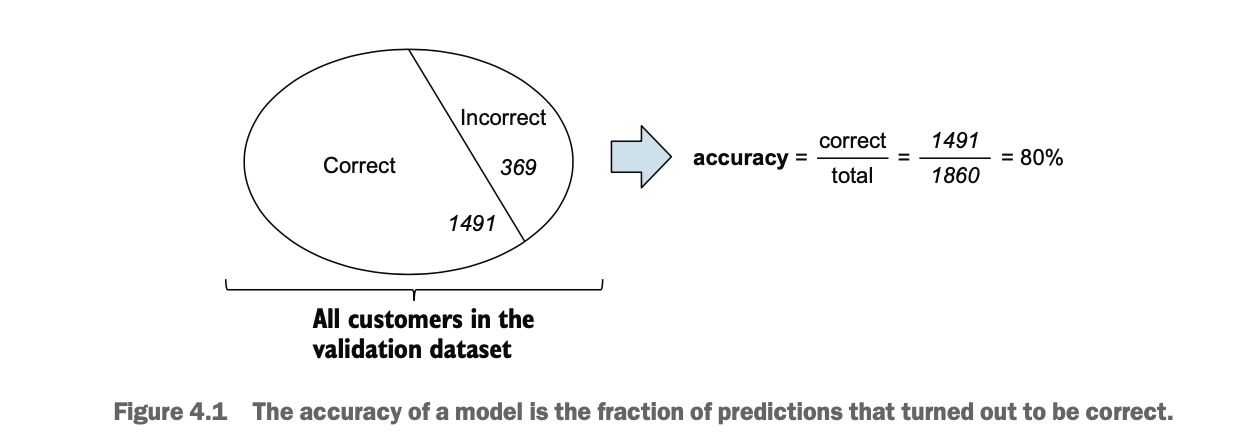

In [10]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8034066713981547

In [11]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

### 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds (currently set at 0.5)
- Check the accuracy of dummy baselines

In [12]:
total_observations = len(y_val)

In [13]:
correct_pred = (y_val == churn).sum()

In [14]:
accuracy = correct_pred / total_observations

In [15]:
#evaluate our predictions for 21 thresholds
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn = (y_pred >= t)
    score = (y_val == churn).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [16]:
#evaluate our predictions for 21 thresholds
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [17]:
from collections import Counter
Counter(y_val)

Counter({0: 1023, 1: 386})

In [18]:
#Customers who will not "churn" and customer who will "churn"
1-y_val.mean(), y_val.mean()

(0.7260468417317246, 0.2739531582682754)

The best accuracy is achieved when cutting the predictions at the 0.5 threshold: if a prediction is higher than 0.5, we predict “churn,” and otherwise, we predict “no churn.”

Why bother when our model is accurate 80% of the time when our y_pred is greater or equal to the threshold of 0.5, and we obtain an accuracy of 72% when our y_pred is == to the threshold of 1 (dummy model).

A threshold of 1 is telling us that no one will churn, will always output False and will have an decent accuracy of 72%

WHAT HAPPENS HERE IS THAT OUR MODEL is imbalanced, we have more non-churning (1,023)
users than churning ones (386). We have 3 times more non-churning than churning.

When we are trying to predict a class and turns out to be the majority class and we have class imbalance, the dummy models will always have a good accuracy. Accuracy is a misleading score for cases with class imbalance.

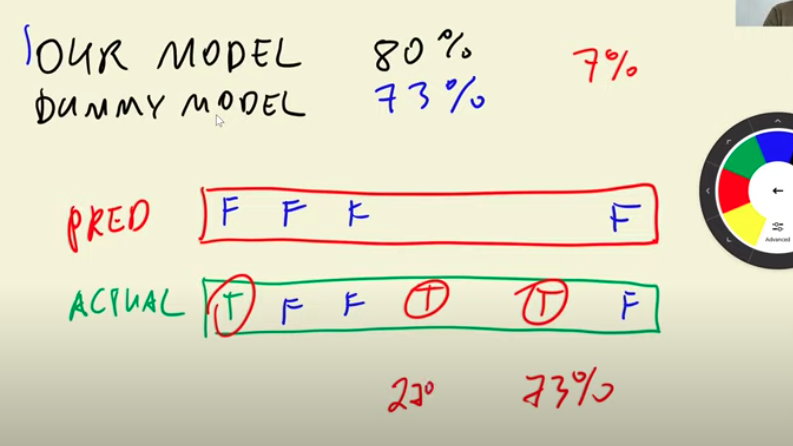

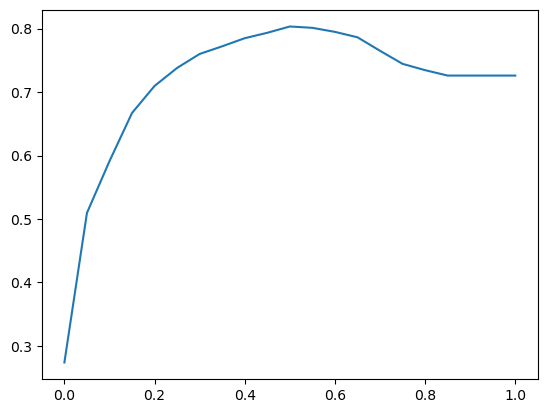

In [19]:
plt.plot(thresholds, scores)
plt.show()

### 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

Even though accuracy is easy to understand, it’s not always the best metric. In fact, it sometimes can be misleading. We’ve already seen this occur: the accuracy of our model is 80%, and although that seems like a good number, it’s just 6% better than the accuracy of a dummy model that always outputs the same prediction of “no churn.”
This situation typically happens when we have a class imbalance (more instances of one class than another). We know that this is definitely the case for our problem: 74% of customers did not churn, and only 26% did churn.

Applying the <u>confusion table</u> we evaluate the quality of our model, that is not affected by the class imbalance.

For a binary classification model we can have only two possible predictions: True and False. In our case, we can predict that a customer is either going to churn (True) or not (False).

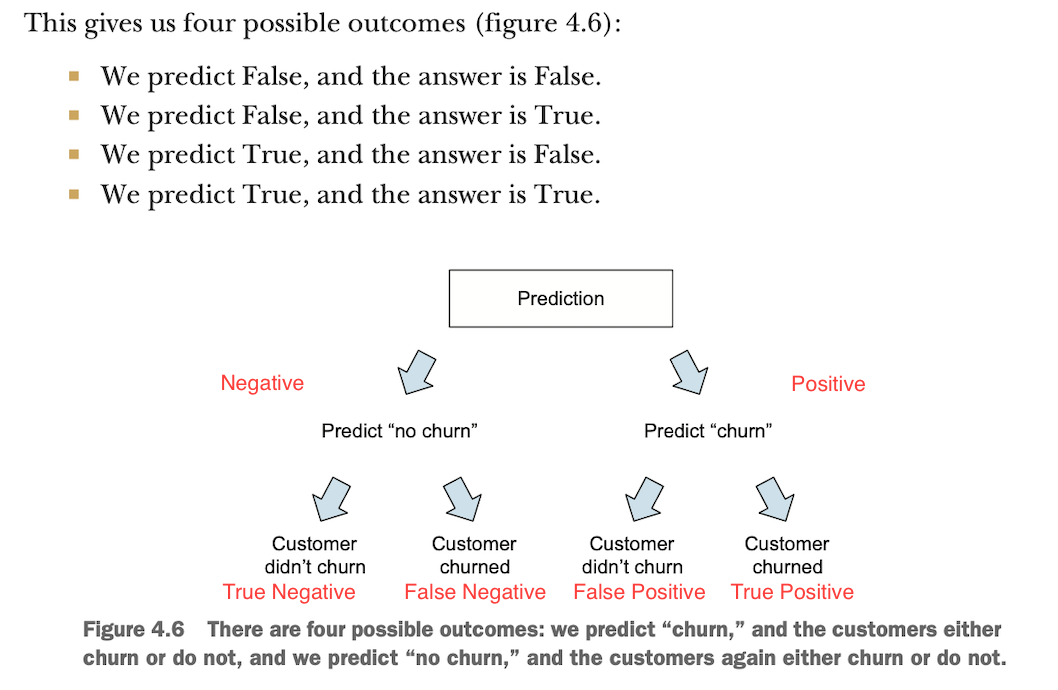

- True negative (TN): we predict False (“no churn”), and the actual label is also False (“no churn”).
- True positive (TP): we predict True (“churn”), and the actual label is True (“churn”).
- False negative (FN): we predict False (“no churn”), but it’s actually True (the customer churned).
- False positive (FP): we predict True (“churn”), but it’s actually False (the cus- tomer stayed with us).

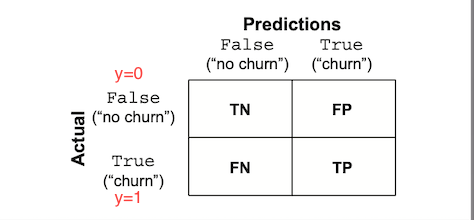

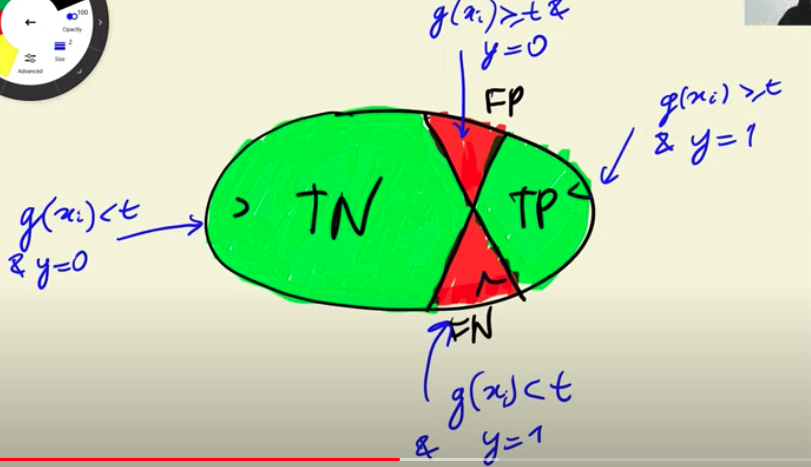




In [20]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

predict_positive = (y_pred >= 0.5)
predict_negative = (y_pred < 0.5)

In [21]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

fn = (actual_positive & predict_negative).sum()
fp = (actual_negative & predict_positive).sum()

tp, tn, fn, fp

(210, 922, 176, 101)

In [22]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [23]:
confusion_matrix_norm = (confusion_matrix/confusion_matrix.sum()).round(2)
confusion_matrix_norm

array([[0.65, 0.07],
       [0.12, 0.15]])

In [24]:
confusion_matrix_norm[1:,0], confusion_matrix_norm[:1,1]

(array([0.12]), array([0.07]))

In [25]:
fp_fn = confusion_matrix_norm[:1,1] + confusion_matrix_norm[1:,0]
fp_fn[0]

0.19

In [26]:
confusion_matrix_norm[1:,1], confusion_matrix_norm[:1,0]

(array([0.15]), array([0.65]))

In [27]:
#by adding tp and tn, we have 80% of accuracy, the same as the previous accuracy metric
tn_tp = confusion_matrix_norm[1:,1] + confusion_matrix_norm[:1,0]
tn_tp[0]

0.8

### 4.4 Precision and recall

Both precision and recall are calculated from the values of the confusion table. They both help us understand the quality of the model in cases of class imbalance.

**The precision of a model:** percentage of positive predictions turned out to be correct. Customers who actually churned (TP) out of all the customers we thought would churn (TP + FP)

P = TP / (TP + FP)

Fraction of positive predictions that were correct

Measure of what it was predicted positive and actually positive, plus what was predicted positive and actually negative.

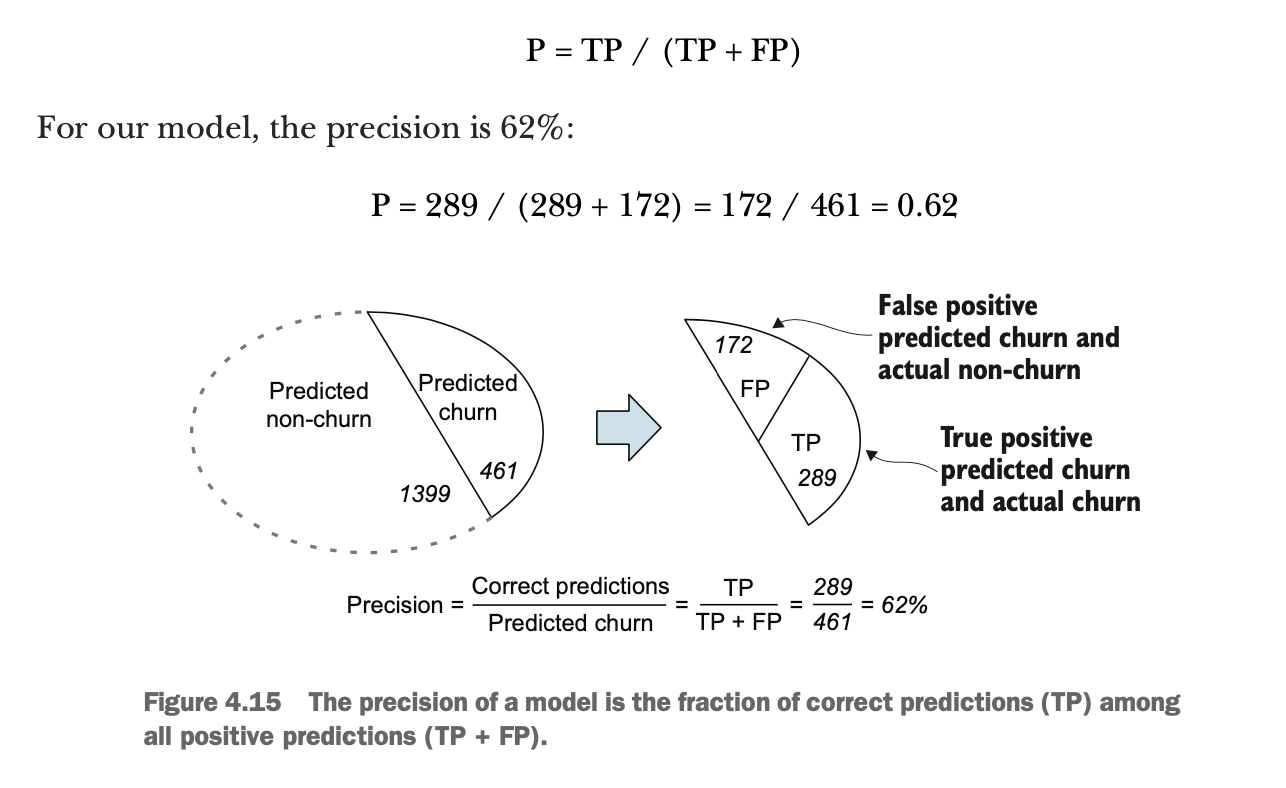

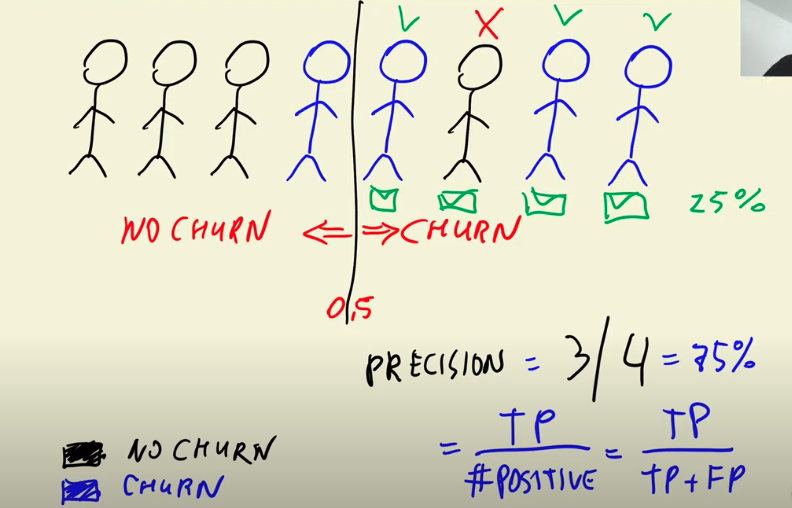

**The recall of a model**: fraction of correctly classified positive examples among all positive examples. In our case, to calculate recall we first look at all the customers who churned and see how many of them we managed to identify correctly.

R = TP / (TP+FN)

Fraction of positive examples that were identified correctly among all positive examples

Measure of what was predicted positive was actually positive, plus what was predicted negative is actually positive. Everything that is actually positive.

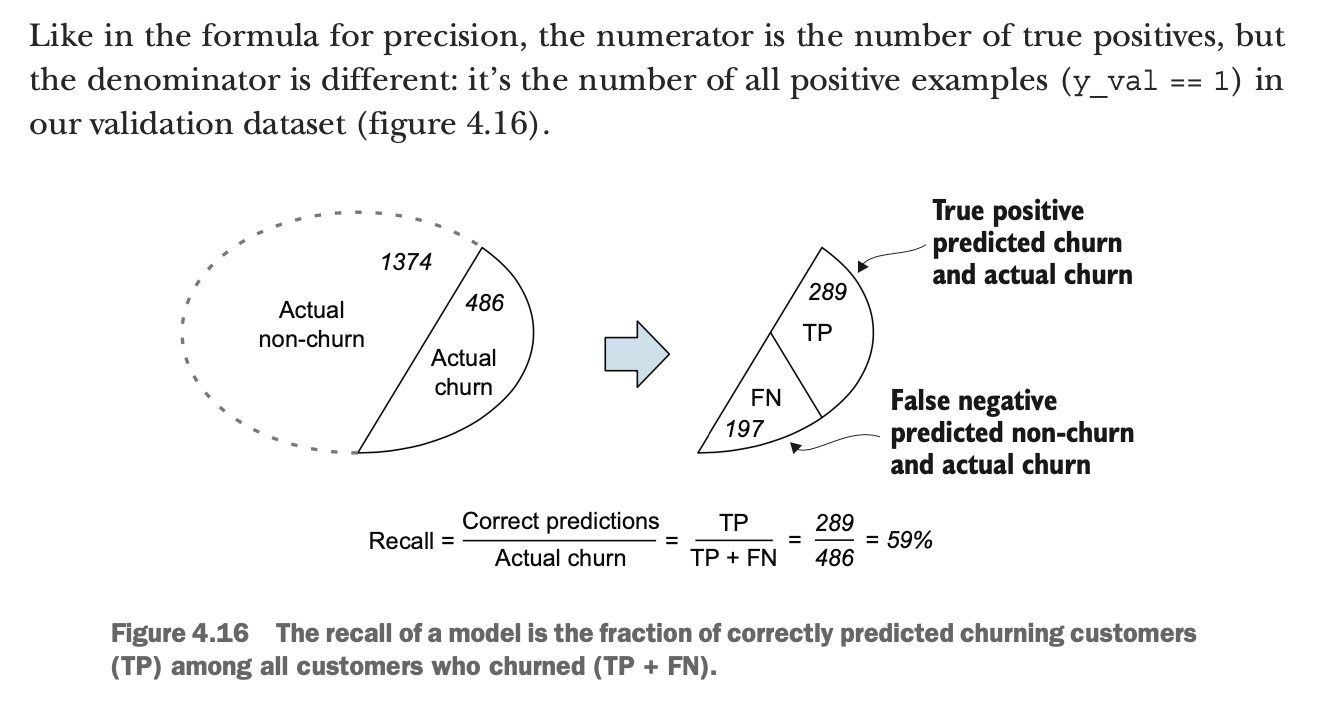

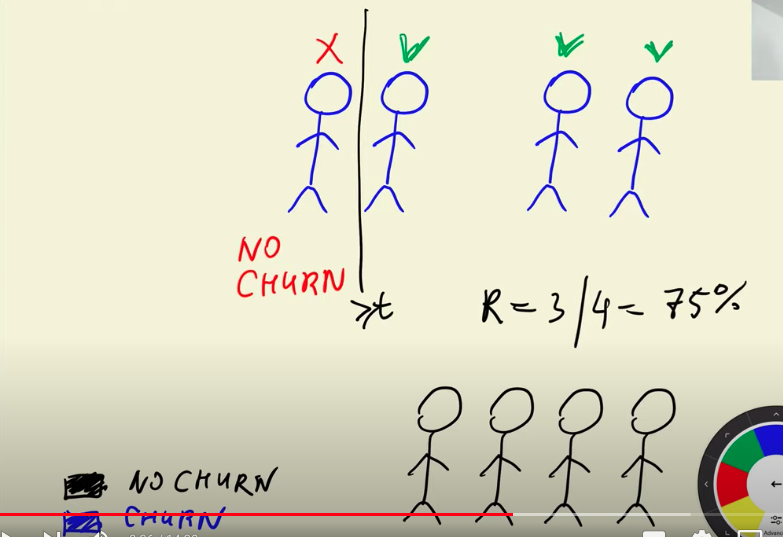

Precision:

311 people were identified as churn customers, but the model 

Based o a threshold, we would send to 311 people a promotinal, and our model correctly predicted that 67% of the customers would churn.

Based on a threshold, our model was able to identify/classify 54% of the cases a person that would churn, but failed 46% to do so.



In [28]:
precision = tp / (tp+fp)
recall = tp / (tp+fn)

precision, recall, accuracy

(0.6752411575562701, 0.5440414507772021, 0.8034066713981547)

A precision of 67% , means that for each customer we want to predict 67% of the time the model will predict it as a churning customer, and 33% of the time will predict a churning customer when is not actually. This means that we will be sending promotionals to 33% of customers that they don't need it.

For each customer we want to predict 54% of the time will be correctly classified as churn customer, but 43% of the time will be classified as non-churning and we will be not sending promotions to these customers

### 4.5 ROC Curves

The metrics we have covered so far work only with binary predictions — when we have only True and False values in the output. However, we do have ways to evaluate the performance of a model across all possible threshold choices. ROC curves is one of these options.

ROC stands for “receiver operating characteristic,” used in WWII to asses how well a detector could separate two signals. Nowadays, **separate two classes, positive and negative. In our case, these classes are “churn” and “no churn.”**

ROC curve is based in two quantities FPR and TPR

- False Positive Rate (FPR): FP / (FP + TN)
    - Is the fraction of users we predicted as churning among everybody who didn’t churn. A small value for FPR tells us that a model is good — it has few false positives


- True Positive Rate (TPR): TP / (TP + FN)

    - Is the fraction of users we predicted as churning among everybody who actually churn Note that TPR is the same as recall, so the higher the TPR is, the better.
    
    
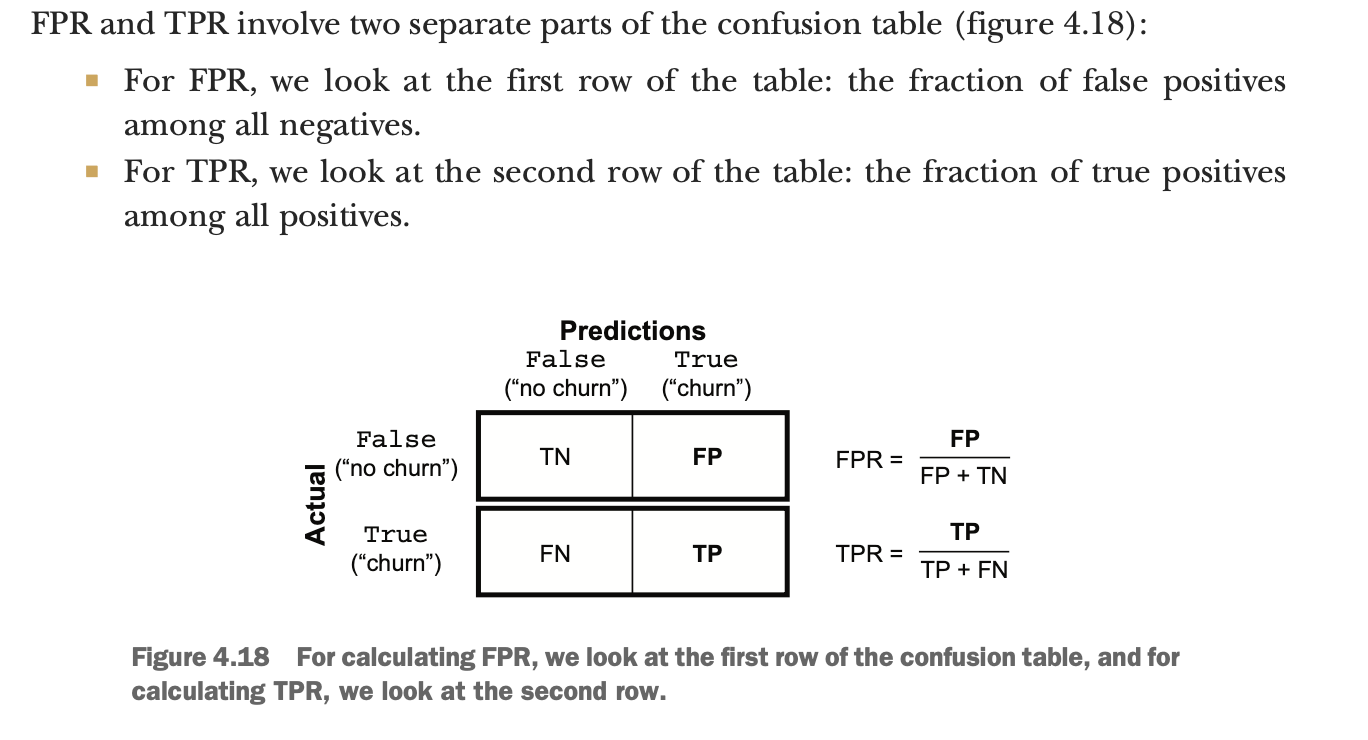

In [29]:
FPR = fp / (fp + tn)
TPR = tp / (tp + fn)

FPR, TPR

(0.09872922776148582, 0.5440414507772021)

We first iterate over different threshold values and compute the values of the confusion table for each.

In [30]:
scores = []

thresholds =np.linspace(0, 1, 101)

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp =((y_pred >= t) & (y_val == 0 )).sum()
    fn = ((y_pred < t ) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    scores.append((t, tp, fp, fn, tn, tpr, fpr))

In [31]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'tpr', 'fpr']

In [32]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,75,20,311,1003,0.194301,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


As the threshold grows, both metrics decline but at different rates.

Ideally, FPR should go down very quickly. A small FPR indicates that the model
makes very few mistakes predicting negative examples (false positives).

On the other hand, TPR should go down slowly, ideally staying near 100% all the time: that will mean that the model predicts true positives well.

**FPR** 

At a threshold of 0 FPR is 100% because we have only false positives:

We incorrectly classify 100% of non-churning customers as churning customers. Nobody is predicted as non-churning, there are no true negative customers

At a threshold of .40 FPR is 20% and the model with a probability of 40% predict non-churn and with a probability of 60% predicts churn

We incorrectly classify 20% of non-churn customers as churning ones.

**TPR**

At a threshold of 0 TPR is 100% because we only have true positives, we can correctly clssify all churning customers a churning customers

At a threshold of .40 the TPR is 70% and the model with a probability of 40% predict non-churn and with a probability of 60% predicts churn

We correctly classify 70% of churning customers as churning ones.

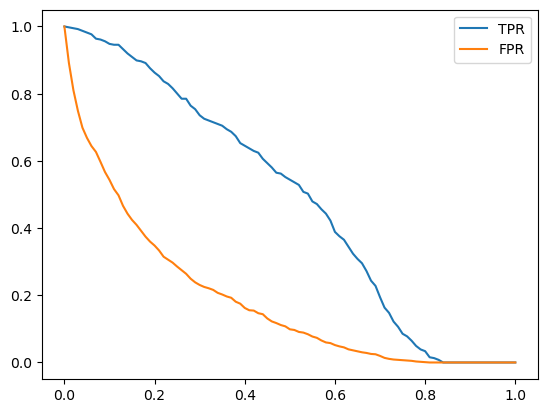

In [33]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()
plt.show()

### Random Model 

In [34]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size = len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [35]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [36]:
def trp_fpr_dataframe(y_val, y_pred):
    
    scores = []
    
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp =((y_pred >= t) & (y_val == 0 )).sum()
        fn = ((y_pred < t ) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        scores.append((t, tp, fp, fn, tn, tpr, fpr))
        
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'tpr', 'fpr']
        
    return df_scores

In [37]:
df_rand = trp_fpr_dataframe(y_val, y_rand)

In [39]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


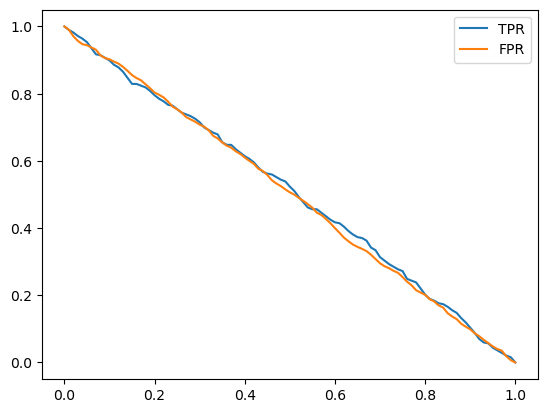

In [41]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
plt.show()

### Ideal model

In [43]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [52]:
y_ideal = np.repeat ([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [51]:
y_ideal_pred = np.linspace(0,1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [61]:
1 - y_val.mean()

0.7260468417317246

In [50]:
((y_ideal_pred>=.7260)==y_ideal).mean()

1.0

In [57]:
(y_val == churn).mean()

0.7260468417317246

In [65]:
Counter(churn.astype(int))

Counter({0: 1409})

In [63]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [74]:
df_ideal = trp_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


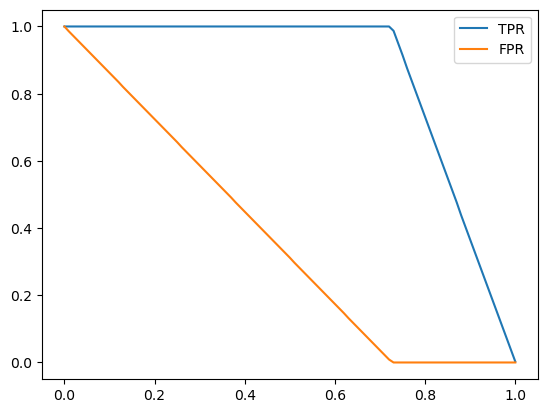

In [68]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()
plt.show()

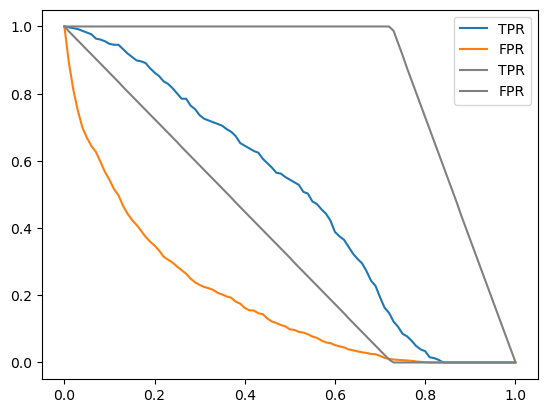

In [76]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='grey')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='grey')

plt.legend()
plt.show()

### ROC Curve

Our models should always be somewhere between these two curves. We want our model to be as close to the ideal curve as possible and as far as possible from the ran- dom curve.

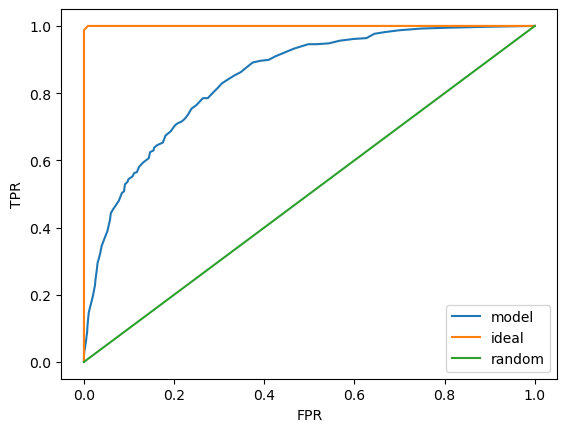

In [86]:
plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')
plt.plot([0,1], [0,1], label = 'random')
#plt.plot(df_rand.fpr, df_rand.tpr, label = 'random')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [87]:
from sklearn.metrics import roc_curve

In [88]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

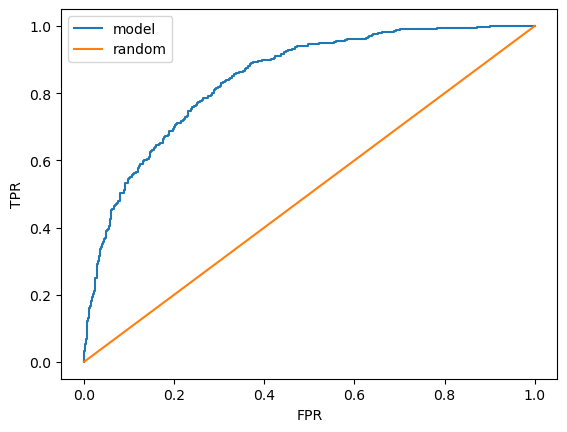

In [90]:
plt.plot(fpr, tpr, label = 'model')
plt.plot([0,1], [0,1], label = 'random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()